# Spaceship Prediction

The purpose of this project is to predict which passengers were transported by the anomaly. So, this prediction is for Classification problem.

Evaluation should be used Accuracy.

---

**Then let's get start!!**

## Import Data and libraries


In [2]:
# importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # 보여지는 최대 칼럼 수 지정할 수 있음.
pd.options.display.max_seq_items = 8000 
pd.options.display.max_rows = 8000


# importing the data : using function
def read_data():
    train_data = pd.read_csv('data/spaceship/train.csv')
    test_data = pd.read_csv('data/spaceship/test.csv')
    return train_data, test_data
    

In [3]:
train_data, test_data = read_data()

## Explore the data

In [4]:
# exploring forest of the data
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### Explore the feature

- PasssengerId : 승객 고유 아이디(문자열)
- HomePlanet : 승객의 출신 행성(문자열) --> **범주형?**
- CryoSleep : 동면머신을 사용했는지의 여부(문자열) --> **False/True의 값을 가지므로 범주형**
- Cabin : 승객이 어디서 머물고 있는지를 나타냄(문자열) --> deck/num/side , **해당열을 분리해야할지 고민할 필요, 범주형**
- Destination : 승객의 목적지 행성(문자열) --> **분류가 될 수도 있음**
- Age : 승객의 나이(실수)
- VIP : vip 고객인지 아닌지의 여부(문자열) --> **False/True 의 값을 가지므로 범주형**
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck : 승객들이 해당 서비스를 얼마나 사용했는지를 나타냄(모두 실수)
- Name : 승객의 이름(문자열)
- Transported : 레이블값.(boolean) 다른 차원으로 옮겨졌는지의 여부(False/True : 이진분류)

> 시각화를 위해서 문자열인 열들을 정수형으로 바꿔주도록 한다.

In [6]:
# 레이블값부터 숫자형으로 바꿔준다.
train_data['Transported'] = train_data['Transported'].astype('int')

In [7]:
# 학습 데이터와 테스트 데이터의 데이터개수, 그리고 피처 수를 확인해보자. (.shape 활용)

print('Train data shape = ', train_data.shape)
print('Test data shape = ', test_data.shape)

Train data shape =  (8693, 14)
Test data shape =  (4277, 13)


```
대략적으로 학습 데이터가 테스트 데이터보다 2배 많은 것을 확인했다.
```

### **Explore Missing data**

In [8]:
print('Missed Data in train data :')
print(train_data.isnull().sum())
print('-' * 50)
print('Missed data in test data : ')
print(test_data.isnull().sum())

Missed Data in train data :
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
--------------------------------------------------
Missed data in test data : 
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


#### **<일반적인 결측치 처리 가이드라인>**

- 10% 미만 : 삭제 or 대치(imputation)
- 10 ~ 20% : **hot deck(이전의 자료 -> 해당 자료 추정)** or **regression** or **model based imputation**
- 20 ~ 50% : **regression** or **model based imputataion**
- 50% 이상 : 해당 칼럼 제거

> 참고로 결측치를 그냥 제거하는 경우는 거의 없다고 한다.

- 대치 값 종류
   - 최빈값
   - 중앙값
   - 평균
   - 조건부 대치
   - 회귀분석 이용한 대치

In [9]:
# 숫자형 변수들에 대한 통계치들을 확인한다.
train_data.describe() 

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


> 레이블인 Transported 의 평균을 통해 다른 차원으로 옮겨진 승객의 비율과 그렇지 않은 승객의 비율이 거의 동일한 것으로 보인다. 어매니티 서비스의 이용은 편차가 매우 큰것으로 보아 사람들마다 이용의 정도가 매우 상이한 것을 추측할 수 있다. 하지만 공통적인 것은 승객의 50% 이상은 어떤 어매니티 서비스도 사용하지 않는다는 점이다. 나이변수의 분포를 통해 승객의 75%는 38세보다 나이가 어린것으로 확인된다.


In [10]:
# 문자열인 열도 분포를 확인해보자. --> train_data.describe(include=['O'])
train_data.describe(include=['O']) # O means object

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


```
homeplanet은 3가지로 나뉘고, 그중에 가장 많이 나온 빈도수가 4602인데, top 종류가 Earth이므로 지구가 가장 많은 승객의 고향행성이다. 
과반수의 승객이 동면상태를 선택하지 않았고, 몇몇 사람들은 cabin을 함께 사용하기도 한다는 점을 알았다. 목적지는 3군데로 나뉘는데 대부분의 승객들이 'TRAPPIST-1e'에 간다는 것을 확인했다. 또한 대부분의 사람들은 vip가 아니고, vip인 사람들의 수는 199명이다.
```

In [11]:
# eda를 위해 passengerid와 cabin 열을 수정해보자.
# train, test 모두 수정할 것이기 떄문에 수정하기 전에 미리 test데이터의 기존 passengerID를 따로 복사해둔다.

# saving the test ids:
Test_Id = test_data.PassengerId

combine = [train_data, test_data]

for dataset in combine: # train_data -> test_data
    # extract passenger group
    dataset["PassengerGroup"] = dataset["PassengerId"].str.split('_', expand=True)[1].astype(int).astype(str) # 기존 passengerid의 '_' 뒤에 오는 값을 가지는 변수 생성
    dataset.drop(columns = ["PassengerId"], axis=1, inplace=True) # 기존 passengerid는 삭제
    
    # extract cabin num, deck, side
    dataset["deck"] = dataset["Cabin"].str.split('/',expand=True)[0]
    dataset["num"] = np.nan_to_num(dataset["Cabin"].str.split('/',expand=True)[1].astype(float)).astype(int) # np.nan_to_num() 함수는 nan->0, -inf->최솟값, +inf->최댓값으로 변경해준다.
    dataset["side"] = dataset["Cabin"].str.split('/',expand=True)[2]
    dataset.drop(["Cabin"],axis=1, inplace=True)
    

print(f'Available decks are {train_data.deck.unique().shape[0]} decks : {train_data.deck.unique()}')
print(f'Available nums are {train_data.num.unique().shape[0]} nums : {train_data.num.unique()}')
print(f'Available sides are {train_data.side.unique().shape[0]} sides : {train_data.side.unique()}')

Available decks are 9 decks : ['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
Available nums are 1817 nums : [   0    1    2 ... 1892 1893 1894]
Available sides are 3 sides : ['P' 'S' nan]


## EDA

In [12]:
# for survived_bar_plot by each categorical features
def survived_bar_plot(feature, ax=None, font_scale=0.8): # ax는 뒤의 subplot만들시에 따로 지정해줄 것이다.
    sns.set(font_scale=font_scale)
    data = train_data[[feature,'Transported']].groupby([feature], as_index=False).mean().sort_values('Transported', ascending=False) # 각 피처의 범주에 따른 transported의 평균 값-> 다른 차원으로 이동되었을 확률
    # draw the plot
    plot = sns.barplot(data=data, x=feature, y='Transported', ci=None, ax=ax )
    plot.set_title(f"{feature} VS Transported")
    plot.set(xlabel=None)
    plot.set(ylabel=None)
    plot.bar_label(plot.containers[0], fmt='%.2f') # 막대 그래프 위에 주석을 달아주는 기능이다. 

#### **<오차 막대(error bar) -> 'ci' 수정하기>**
seaborn은 barplot() 함수를 사용할 때 각 막대에 기본적으로 오차막대(error bar)가 함께 나타나도록 되어 있다.

그리고 이 오차막대를 그리는 범위는 기본적으로 ‘부트 스트랩 신뢰구간(Bootstrap confidence interval)’이라는 것을 사용한다. “이 데이터를 기반으로 유사한 상황의 95 %가이 범위 내에서 결과를 얻을 것”을 의미한다. 이 신뢰 구간은 평균(mean) 외에도 중앙값(median), 최빈값(mode) 등의 다른 값들을 함께 고려해서 계산하는 것이기 때문에 꽤나 훌륭한 수치라고 봐도 된다.

만약 이 오차막대에 신뢰구간이 아니라 표준편차를 표현하고 싶다면 sns.barplot() 안에 ci="sd"라고 지정하면 된다.

#### **seaborn 축 레이블 설정하기**

1. set_xlabel() / set_ylabel()
2. set()
3. matplotlib.pyplot.xlabel() / matplotlib.pyplot.ylabel()

In [13]:
def survived_table(feature):
    return train_data[[feature,'Transported']].groupby([feature], as_index=False).mean().sort_values(by='Transported', ascending=False).style.background_gradient(low=0.75,high=1) # style.background_gradient는 데이터의 수치를 색상의 온도로 보는 시각화다.

# for survived_bar_plot by each numerical features
def survived_hist_plot(feature, bin_width=5): # 값의 폭을 5단위로
    plt.figure(figsize=(6,4))
    sns.histplot(data=train_data, x = feature, hue='Transported', binwidth = bin_width, palette=sns.color_palette(['yellow','green']), multiple='stack').set_title(f'{feature} VS Transoported') # hue의 카테고리를 위로 쌓아 누적된 형태로 그리기
    plt.show()

### Count of Target 

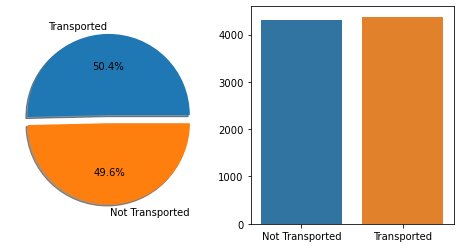

In [14]:
# count of transported passengers

# pie chart
f, ax = plt.subplots(1,2,figsize=(8,4))
train_data['Transported'].replace({0:'Not Transported',1:'Transported'}).value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_ylabel('')

# countplot
sns.countplot(x = train_data['Transported'].replace({0:'Not Transported', 1:'Transported'}), ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('')

plt.show()

```
Not transported 와 Transported의 비율이 거의 동일하다 --> 비대칭분포는 아니다.
```

#### Pie Chart
- matplotlib.pyplot.pie(x, explode=None, labels=None, colors=None, autopct=None, pctdistance=0.6, shadow=False, labeldistance=1.1, startangle=None, radius=None, counterclock=True, wedgeprops=None, textprops=None, center=(0,0), frame=False, rotatelabels=False)

- x : 필수
- explode : 각 항목을 파이의 원점에서 튀어 나오는 정도를 나타낸다. 튜플로 묶어줘야 한다.
- labels : 각 항목의 이름을 지정한다. 리스트로 묶어줘야 한다.
- colors : 각 항목의 색을 지정한다. 리스트로 묶어줘야 한다.
- autopct : 각 항목의 퍼센트를 표시한다. 문자형으로 표시 -> ex) autopct = '%.2f'
- pctdistance : 퍼센트를 표시할 위치를 지정한다.(중앙에서의 거리), default=0.6
- shadow : 그림자를 나타낼 것인지의 여부를 설정한다. (True,False)
- labeldistance : 레이블을 표시할 거리를 설정한다. (중앙에서의 거리), default=1.1
- startangle : x축에서 반시계 방향으로의 시작 각도를 설정한다. 
- radius : 파이의 반지름을 설정한다. default = 1
- counterclock : 각 항목을 표현하는 방향을 반시계방향으로 할 것인지의 여부. default = True
- wedgeprops : 웨지 속성을 설정한다. 딕셔너리로 묶어준다. ex) wedgeprops = dict(edgecolor='black', linewidth=3, linestyle=':')
- textprops : 레이블의 text 속성을 설정한다. 딕셔너리로 묶어준다. ex) textprops = dict(rotation=15, size=12, weight=3, color='red')
- center : 차트의 중심을 설정한다. default=(0,0)
- frame : 차트의 x,y 축을 표현할 지의 여부. default=False
- rotatelabels : 레이블을 각 항목의 방향에 맞게 회전할 지 여부를 설정한다. default=False

#### Categorical features with target 

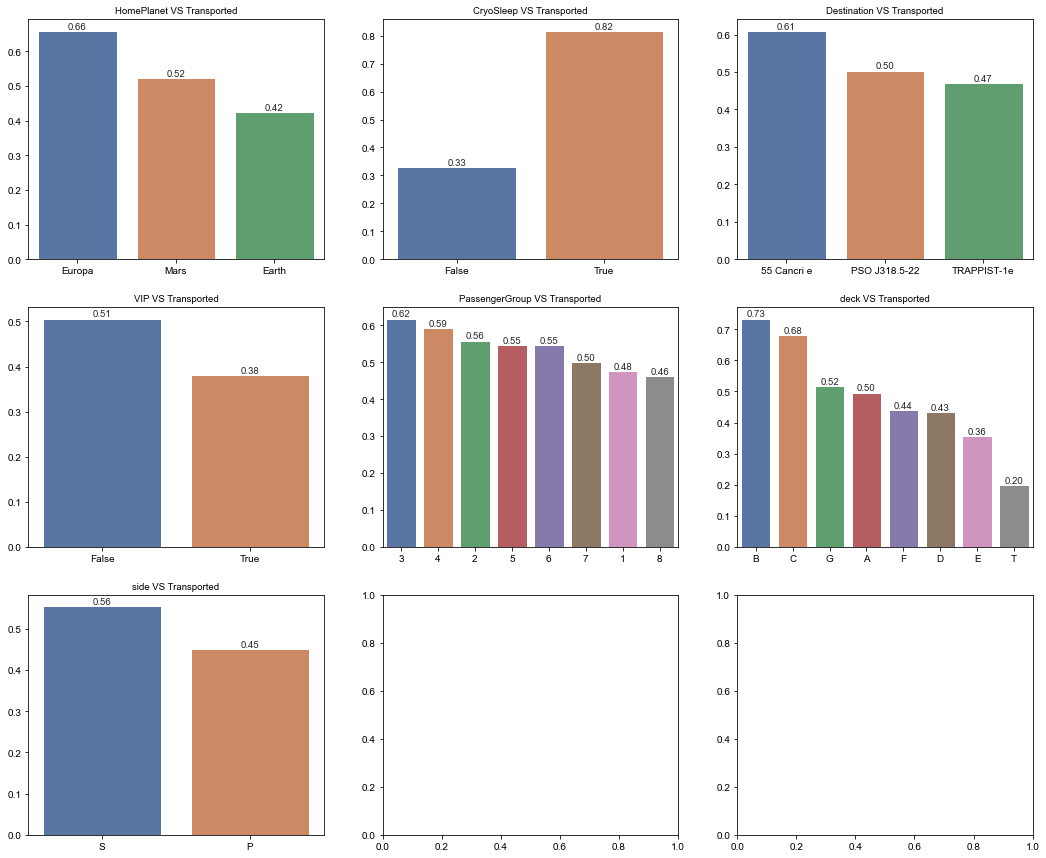

In [15]:
fig, ax = plt.subplots(3,3, figsize=(18,15)) # 9개의 plot을 그리기 위한 subplot. 
survived_bar_plot('HomePlanet', ax[0][0]) # 1행 1열
survived_bar_plot('CryoSleep', ax[0][1]) # 1행 2열
survived_bar_plot('Destination', ax[0][2]) # 1행 3열
survived_bar_plot('VIP', ax[1][0]) # 2행 1열
survived_bar_plot('PassengerGroup', ax[1][1]) # 2행 2열
survived_bar_plot('deck', ax[1][2]) # 2행 3열
survived_bar_plot('side', ax[2][0]) # 3행 1열

```
transported 된 사람들의 고향행성은 europa 가 다른 행성보다 비율이 높다. 승객들의 절반 이상이 고향행성이 Earth 였다는점을 참고한다면 유의미한 정보를 제공해준다.   또, transported 된 사람들은 동면을 선택한 비율이 80% 정도다. 승객들의 절반 이상넘게 동면을 선택하지 않았다는 점을 참고하면 유의미한 정보를 제공해준다.  목적지 같은 경우에는 큰 비율적인 차이는 보이지 않지만 55 Cancri e 가 가장 이전된 비율이 높다. 또한 놀라운 점은 전체 승객 중 VIP인 고객은 2%밖에 되지 않는다. 하지만 이전된 승객들 중에서는 40%가 VIP인 것을 확인할 수 있기 때문에 유의미한 정보다. deck의 비율은 B 와 C가 가장 높다. 
```

#### Numerical features with target

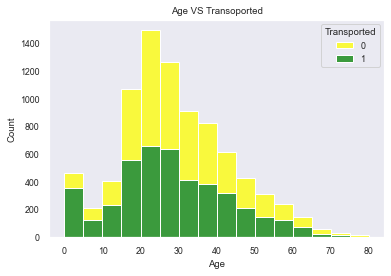

In [16]:
# 1) Age

# using histplot
sns.set_style('dark') # to remove the grid
survived_hist_plot('Age')

```
10살 이하인 아이들이 Transported 된 비율이 가장 큰 것을 확인했다. --> 추후 더 분석할 필요가 있겠다
또한 각 승객 나이 분포에서 절반정도는 transported된 것을 확인할 수 있다. 
```

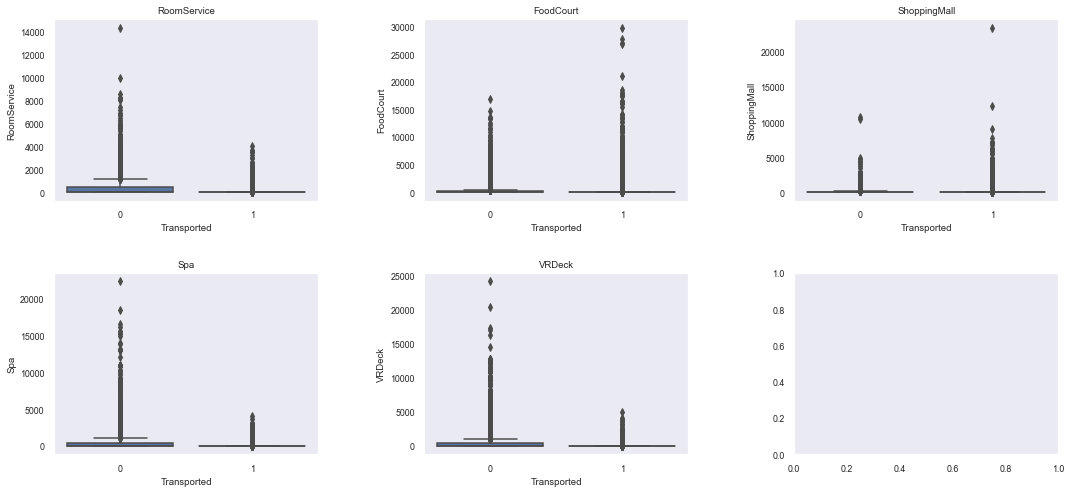

In [17]:
# 2) RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

# using boxplot
plot, ax = plt.subplots(2,3,figsize=(18,8)) #총 6개의 sub차트를 만들었다.

sns.boxplot(data=train_data, x = 'Transported',  y='RoomService', ax=ax[0][0]).set_title('RoomService')
sns.boxplot(data=train_data, x = 'Transported',  y='FoodCourt', ax=ax[0][1]).set_title('FoodCourt')
sns.boxplot(data=train_data, x = 'Transported',  y='ShoppingMall', ax=ax[0][2]).set_title('ShoppingMall')
sns.boxplot(data=train_data, x = 'Transported',  y='Spa', ax=ax[1][0]).set_title('Spa')
sns.boxplot(data=train_data, x = 'Transported',  y='VRDeck', ax=ax[1][1]).set_title('VRDeck')
plt.subplots_adjust(wspace=0.4, hspace=0.4) # 각 서브플롯간의 간격 조정

```
많은 이상치들이 있다는 것을 확인할 수 있다.
```

#### **서브 플롯간의 간격 조절 : subplots_adjust, tight_layout(), constrained_layout**

- fig.tight_layout() : 공백을 줄인다. 
- plt.subplots_adjust(left, bottom, right, top, wspace, hspace) : 현재 배치되어 있는 subplot들의 위치를 직접 조정한다. 
    - left, bottom, right, top : 서브플롯 4면의 위치 조정
    - hspace, wspace : 서브플롯 간의 간격을 위해 각각 figure의 너비와 높이에 대한 비율 조절
- plt.subplots(constrained_layout = True) : 서브플롯간의 간격을 가능한 최적의 수치로 자동 조정해준다. --> 가장 편리

### Correlation between numerical features 

수치형 변수들간의 상관관계를 확인해보자.

<AxesSubplot:>

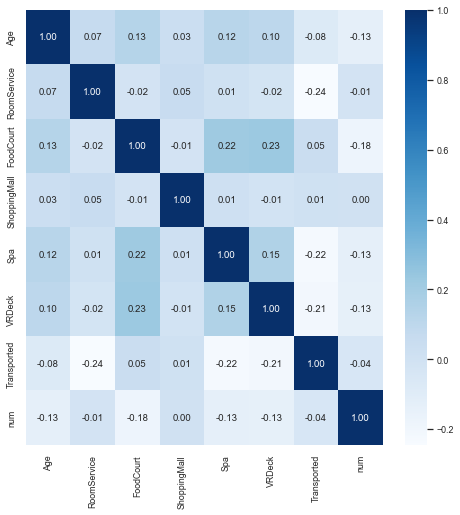

In [18]:
sns.set(font_scale=0.8) # font 사이즈를 조정한다.
plt.figure(figsize=(8,8)) # figure 사이즈를 조정한다.
sns.heatmap(train_data.corr(), annot=True, fmt='.2f', cmap='Blues')

```
딱히 상관관계가 있다고 볼만한 피처들은 없다. 레이블 값과도 상관관계가 있어보이는 피처는 없는것으로 확인된다.
```

##### sns.heatmap
- annot : bool, True ->  write the data value in each cell.
- fmt : str. String formatting code to use when adding annotations.

#### Correlation between numerical and categorical features 

범주형 데이터와 숫자형 데이터간의 관계를 살펴보기 위해서 **boxplot** 으로 나타내보자.

<AxesSubplot:xlabel='deck', ylabel='Age'>

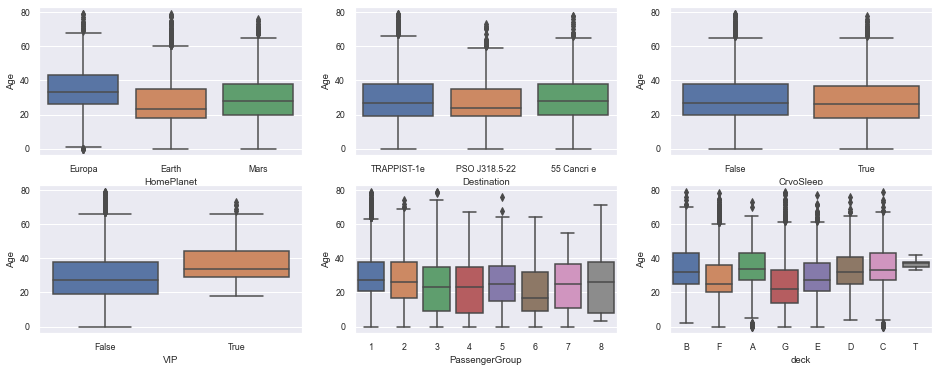

In [19]:
# 1) Age 와 타 범주형 데이터간의 관계
plot, ax = plt.subplots(2,3,figsize=(16,6))
sns.boxplot(data=train_data, y = 'Age', x = 'HomePlanet', ax=ax[0][0])
sns.boxplot(data=train_data, y = 'Age', x = 'Destination', ax=ax[0][1])
sns.boxplot(data=train_data, y = 'Age', x = 'CryoSleep', ax=ax[0][2])
sns.boxplot(data=train_data, y = 'Age', x = 'VIP', ax=ax[1][0])
sns.boxplot(data=train_data, y = 'Age', x = 'PassengerGroup', ax=ax[1][1])
sns.boxplot(data=train_data, y = 'Age', x = 'deck', ax=ax[1][2])

```
'Age' 열의 결측값을 채우는 방법으로 PassengerGroup 을 사용하면 적절할 것으로 판단된다.
```

### Data Processing

In [20]:
transported = train_data['Transported'] # 레이블데이터
all_data = pd.concat([train_data, test_data]).reset_index(drop=True) # 학습 데이터 + 테스트 데이터 = 전체 데이터, 원본 인덱스 제거
all_data.drop(columns=['Transported'], inplace=True)

#### Filling Missed Values

In [21]:
all_data.isnull().sum()

HomePlanet        288
CryoSleep         310
Destination       274
Age               270
VIP               296
RoomService       263
FoodCourt         289
ShoppingMall      306
Spa               284
VRDeck            268
Name              294
PassengerGroup      0
deck              299
num                 0
side              299
dtype: int64

In [22]:
# 일단, HomePlanet, CryoSleep, Destination, VIP 의 결측치부터 채워보자.
# 모두 각 열의 최빈값으로 바꾸도록 한다. 
print(all_data["HomePlanet"].mode()[0]) 
all_data['HomePlanet'] = all_data['HomePlanet'].fillna(all_data['HomePlanet'].mode()[0])
all_data['CryoSleep'] = all_data['CryoSleep'].fillna(all_data['CryoSleep'].mode()[0])
all_data['Destination'] = all_data['Destination'].fillna(all_data['Destination'].mode()[0])
all_data['VIP'] = all_data['VIP'].fillna(all_data['VIP'].mode()[0])

Earth


In [23]:
# 다음으로 age열의 결측치는 passengergroup 열을 사용해서 채워넣는다.
PassengerGroups  = ['1','2','3','4','5','6','7','8']
median_ages = {} # 빈 딕셔너리 생성
for passengergroup in PassengerGroups:
    median_ages[passengergroup] = all_data.loc[all_data['PassengerGroup'] == passengergroup,'Age'].median()
    
for index, passenger in all_data.iterrows():
    if pd.isna(passenger['Age']):
        all_data.at[index,'Age'] = median_ages[passenger['PassengerGroup']]

- iterrows() : 데이터프레임의 행 반복하기

하나하나의 행을 참조하여 for loop을 돌리는 경우에 사용한다.
**데이터프레임** 에 적용할 수 있으며 결과로 iterrows 객체를 반환한다. 

> **iterrows 객체** 는 데이터프레임의 각 행 정보를 담은 객체라고 보면 된다.

> (dataframe index, row_series) 의 튜플이 iterrows 객체의 모습이라고 보면 된다. 

> 주의할 점은 iterrows가 갖게되는 행 순서는 데이터프레임의 인덱스와는 상관 없이 iterrows가 적용된 데이터프레임의 가장 위쪽 행부터 참조한다는 것이다.


---
> [] 를 사용한 인덱싱은 많은 입력을 받을 수 있는만큼 많은 작업을 처리해야 하기 때문에 성능이 좋지는 않다. 

> **.at** 과 **.iat**은 하나의 스칼라값에만 접근하고 싶을 때 사용함으로서 성능을 개선할 수 있다. (loc, iloc과 사용은 같다)
- .at() : 하나의 스칼라값에만 접근하고 싶다면 사용한다. 레이블 기반으로 데이터에 접근한다. (=loc)
    - series.at['index_label']
    - dataframe.at['index_label','column_label']
- .iat() : 하나의 스칼라값에만 접근하고 싶다면 사용. 위치 정수 기반으로 데이터에 접근한다. (=iloc)
    - series.iat[index_int]
    - dataframe.iat[index_int, column_int]
    
> 대략 at/iat 메소드가 loc/iloc 메소드에 비해 1.5배 정도 빠르다고 한다.

In [24]:
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck 결측치 채우기
# 수치형 데이터는 중앙값으로 대체해보자. 
all_data['RoomService'] = all_data['RoomService'].fillna(all_data['RoomService'].median()[0])
all_data['FoodCourt'] = all_data['FoodCourt'].fillna(all_data['FoodCourt'].median()[0])
all_data['ShoppingMall'] = all_data['ShoppingMall'].fillna(all_data['ShoppingMall'].median()[0])
all_data['Spa'] = all_data['Spa'].fillna(all_data['Spa'].median()[0])
all_data['VRDeck'] = all_data['VRDeck'].fillna(all_data['VRDeck'].median()[0])

In [25]:
# deck,side(범주형) 의 결측치 채워넣기
# 마찬가지로 최빈값으로 채워넣기

all_data['deck'] = all_data['deck'].fillna(all_data.deck.mode()[0])
all_data.side = all_data.side.fillna(all_data.side.mode()[0])

In [26]:
# Name 결측치 채워넣기 -> None 으로
all_data.Name = all_data.Name.fillna('None')

In [27]:
# 모든 열의 결측치가 해결되었는지 확인
all_data.isnull().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name              0
PassengerGroup    0
deck              0
num               0
side              0
dtype: int64

### Data Engineering


In [28]:
# 가족의 수를 알 수 있는 FamilySize 열 생성
all_data['LastName'] = all_data.Name.str.split(' ', expand=True)[1] # Name 열에서 성만 따로 빼서 다른 열로 할당
last_name_count = all_data.Name.str.split(' ', expand=True)[1].value_counts() # 이름의 성별로 몇 개의 데이터가 있는지 확인 -> 객체 저장
all_data['FamilySize'] = [last_name_count[x] if not pd.isna(x) else None for x in all_data['LastName']] # 성이 있으면 last_name_count값을 넣고 없으면 None값을 넣어서 FamilySize 변수 만들기
all_data['FamilySize'] = all_data['FamilySize'].fillna(0) # 결측치 값은 0으로 바꾸기
all_data.drop(columns = ['LastName','Name'], inplace=True) # LastName 열과 기존의 Name 열을 삭제

In [29]:
# 비행동안 사용한 서비스의 총 금액을 담고 있는 MoneySpent 열 생성
# 어메니티 서비스와 관려된 열은 레이블 변수에 큰 영향을 주는 것 같지 않기 때문에 (위의 boxplot 참고) 
all_data['MoneySpent'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data['Spa'] + all_data['VRDeck']

In [30]:
# MoneySpent를 카테고리화 할 수 있다. -> 'SpendCategory'
# 따로 따로 수치형 변수로 존재하는 것보다 어메니티 서비스에 총 들인 금액으로 카테고리화하면 차원도 줄이고 효율도 높아질 것이다. 
all_data['SpendCategory'] ='' # 빈 문자열 할당 (object)
all_data.loc[all_data['MoneySpent'].between(0,1,'left'), 'SpendCategory'] = 'Zero_Spend'
all_data.loc[all_data['MoneySpent'].between(1,800,'both'),'SpendCategory'] = 'Under_800'
all_data.loc[all_data['MoneySpent'].between(800,1200,'right'), 'SpendCategory'] = 'Median_1200'
all_data.loc[all_data['MoneySpent'].between(1200,2700,'right'), 'SpendCategory'] = 'Upper_2700'
all_data.loc[all_data['MoneySpent'].between(2700,100000,'right'), 'SpendCategory'] = 'Big_Spender'
all_data['SpendCategory'] = all_data['SpendCategory'].astype('category') # 카테고리형으로 변환

In [31]:
# AnySpend : 서비스를 사용했는지의 여부를 알 수 있는 열 (boolean 형)
all_data['AnySpend'] = all_data['MoneySpent'] > 0

In [32]:
# IsChild : 승객의 나이가 10살 이하인지의 여부를 알 수 있는 열 (boolean 형)
# 앞서 transported=1인 데이터에 10살 이하인 애들이 많았기 때문에 
all_data['IsChild'] = all_data['Age'] <= 10

In [33]:
all_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,deck,num,side,FamilySize,MoneySpent,SpendCategory,AnySpend,IsChild
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,1,B,0,P,3.0,0.0,Zero_Spend,False,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,F,0,S,4.0,736.0,Under_800,True,False
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,1,A,0,S,7.0,10383.0,Big_Spender,True,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,2,A,0,S,7.0,5176.0,Big_Spender,True,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,F,1,S,9.0,1091.0,Median_1200,True,False


### Preparing for Training

In [34]:
# converting boolean to int for modeling
all_data['CryoSleep'] = all_data['CryoSleep'].astype(int)
all_data['VIP'] = all_data['VIP'].astype(int)
all_data['AnySpend'] = all_data['AnySpend'].astype(int)
all_data['IsChild'] = all_data['IsChild'].astype(int)

# FamilySize도 아예 정수형으로 바꿔주자 
all_data['FamilySize'] = all_data['FamilySize'].astype(int)

In [35]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   HomePlanet      12970 non-null  object  
 1   CryoSleep       12970 non-null  int32   
 2   Destination     12970 non-null  object  
 3   Age             12970 non-null  float64 
 4   VIP             12970 non-null  int32   
 5   RoomService     12970 non-null  float64 
 6   FoodCourt       12970 non-null  float64 
 7   ShoppingMall    12970 non-null  float64 
 8   Spa             12970 non-null  float64 
 9   VRDeck          12970 non-null  float64 
 10  PassengerGroup  12970 non-null  object  
 11  deck            12970 non-null  object  
 12  num             12970 non-null  int32   
 13  side            12970 non-null  object  
 14  FamilySize      12970 non-null  int32   
 15  MoneySpent      12970 non-null  float64 
 16  SpendCategory   12970 non-null  category
 17  AnySpend    

In [36]:
# object 또는 category 로 되어 있는 변수들을 더미변수화 한다. 
all_data = pd.get_dummies(all_data)

In [37]:
all_data.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,num,FamilySize,MoneySpent,AnySpend,IsChild,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,PassengerGroup_1,PassengerGroup_2,PassengerGroup_3,PassengerGroup_4,PassengerGroup_5,PassengerGroup_6,PassengerGroup_7,PassengerGroup_8,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,side_P,side_S,SpendCategory_Big_Spender,SpendCategory_Median_1200,SpendCategory_Under_800,SpendCategory_Upper_2700,SpendCategory_Zero_Spend
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,3,0.0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,0,4,736.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,7,10383.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,7,5176.0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,9,1091.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0


In [38]:
# 다시 훈련 데이터와 테스트 데이터를 나눈다. 
train_data = all_data[:len(train_data)]
test_data = all_data[len(train_data):]

### Modeling

In [39]:
# load library for binary classification
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier # 랜덤포레스트, 에이다부스트, 그래디언트부스트, 엑스트라트리, 투표기반분류기
from sklearn.linear_model import LogisticRegression, SGDClassifier # 로지스틱 회귀
from sklearn.neighbors import KNeighborsClassifier  # knn
from sklearn.tree import DecisionTreeClassifier # 결정트리
from sklearn.svm import SVC # 서포트벡터머신
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import XGBClassifier # xgboost 

# import evaluation indicator for classification
from sklearn.metrics import precision_score, recall_score, f1_score

In [40]:
# preparing data for training
Y_train = transported 
X_train = train_data 
X_test = test_data
print(f'X_train shape is = {X_train.shape}')
print(f'Y_train shape is = {Y_train.shape}')
print(f'Test shape is = {X_test.shape}')

X_train shape is = (8693, 42)
Y_train shape is = (8693,)
Test shape is = (4277, 42)


In [41]:
# Cross validate model with KFold stratified cross val
kfold = StratifiedKFold(n_splits=12) # 12개로 교차검증 수행

In [42]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes = np.linspace(.1,1.0,5)):
    '''Generate a simple plot of the test and training learning curve'''
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
    plt.legend(loc='best')
    return plt

#### **sklearn.model_selection.learning_curve**

determines cross-validated training and test scores for different training set sizes

A cross-validation generator splits the whole dataset k times in training and test data. Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the test set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

- train_sizes : default=np.linspace(0.1, 1.0, 5) 
    : Relative or absolute numbers of training examples that will be used to generate the learning curve. If the dtype is float, it is regarded as a fraction of the maximum size of the training set (that is determined by the selected validation method), i.e. it has to be within (0, 1]. Otherwise it is interpreted as absolute sizes of the training sets. Note that for classification the number of samples usually have to be big enough to contain at least one sample from each class.
    
- cv : Determines the cross-validation splitting strategy. 
    - None, to use the default 5-fold cross validation
    - int, to specify the number of folds in a (Stratified)KFold

> For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used. These splitters are instantiated with shuffle=False so the splits will be the same across calls.\


returns below things
- train_sizes : array of shape(n_unique_ticks,) : Numbers of training examples that has been used to generate the learning curve.
- train_scores : array of shape (n_ticks, n_cv_folds) : Scores on training sets.
- test_scores : array of shape (n_ticks, n_cv_folds) : Scores on test set.

#### Matplotlib 그래프 영역 채우기
그래프의 특정 영역을 색상으로 채워서 강조할 수 있다.

- fill_between() : 두 수평 방향의 곡선 사이를 채운다.
- fill_betweenx() : 두 수직 방향의 곡선 사이를 채운다.
- fill() : 다각형 영역을 채운다.

[18:13:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

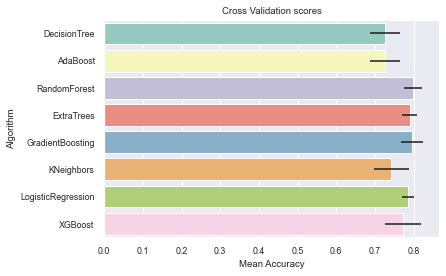

In [43]:
# modeling step Test different algorithms
random_state = 0
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(XGBClassifier(random_state=random_state))
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv=kfold))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CrossValMeans':cv_means, 'CrossValerrors':cv_std, 'Algorithm':['DecisionTree','AdaBoost','RandomForest','ExtraTrees','GradientBoosting','KNeighbors','LogisticRegression','XGBoost']})

g = sns.barplot('CrossValMeans','Algorithm', data=cv_res, palette='Set3', orient='h',**{'xerr':cv_std}) # orient = 'h'/'v'
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation scores')

In [44]:
# Score 로 모델들을 정렬
results = pd.DataFrame({'Model':['DecisionTree','AdaBoost','RandomForest','ExtraTrees','GradientBoosting','KNeighbors','LogisticRegression','XGBoost'],
                       'Score':cv_means,
                       'Std':cv_std})

results.sort_values('Score', ascending=False)

,Model,Score,Std
2,RandomForest,0.799275,0.023514
4,GradientBoosting,0.796514,0.027979
3,ExtraTrees,0.790183,0.019303
6,LogisticRegression,0.785810,0.015385
7,XGBoost,0.772593,0.045347
5,KNeighbors,0.742340,0.045064
0,DecisionTree,0.725655,0.038652
1,AdaBoost,0.725541,0.038236


#### Model tunning

In [45]:
# 1. gradient boosting tunning
GBC = GradientBoostingClassifier(random_state=random_state)

# gb_param_grid = {'loss' : ['deviance'], 'n_estimators':[600,800], 'learning_rate':[0.01],'max_depth':[14,16],'min_samples_leaf':[20,25],'max_features':[0.03,0.05,0.1]
#}

gb_param_grid = {
    'learning_rate':[0.01],
    'max_depth':[14],
    'min_samples_leaf':[25],
    'max_features':[0.05],
    'n_estimators':[600]
}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=5, scoring='accuracy', verbose=1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

print('The Best Model Parameters is :')
print(GBC_best)
print(f'With Cross Validation Score = {gsGBC.best_score_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
The Best Model Parameters is :
GradientBoostingClassifier(learning_rate=0.01, max_depth=14, max_features=0.05,
                           min_samples_leaf=25, n_estimators=600,
                           random_state=0)
With Cross Validation Score = 0.7997273673546229


In [46]:
print(f'With Cross Validation Score = {gsGBC.best_score_}')

With Cross Validation Score = 0.7997273673546229


#### **tree에 관한 하이퍼파라미터**

- max_depth(default=3)
- min_samples_split(default=2) : 노드를 분할하기 위한 최소한의 샘플 데이터 수
    - 값이 작을수록 과적합 가능성 증가
- min_samples_leaf(default=1) : 리프노드가 되기 위한 최소한의 샘플 데이터 수 
    - 값이 작을수록 과적합 가능성 증가
    - 불균형 데이터인 경우 특정 클래스의 데이터가 적을 수 있으므로 이때는 작은 값으로 설정해줘야 함.
- max_features(default=None) : 최적 분할을 위해 고려하는 피처의 최대 개수
    - int 형 : 피처 갯수
    - float 형 : 전체 피처 갯수의 비율로 사용
    - sqrt / auto : 전체 피처 중 sqrt(피처수) 만큼 사용
    - log2 : 전체 피처 중 log2(피처수) 만큼 사용
- max_leaf_nodes(default=None) : 리프노드의 최대 갯수

#### **Boosting에 대한 하이퍼파라미터**

- loss(default='deviance') : 손실함수 지정
- n_estimators(default=100) : 사용할 트리의 갯수를 지정
- learning_rate(default=0.1) : 학습률(0~1)
    - 낮은 값일 수록 에측 성능이 높아지나 수행 시간이 매우 오래 걸림
- subsample(default=1) : 개별 트리가 학습에 사용하는 데이터 샘플링의 비율(0~1)
    - 해당 값을 적절히 조정하면 각 트리간의 상관도를 줄일 수 있다.

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

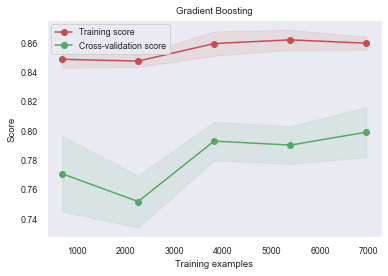

In [47]:
plot_learning_curve(GBC_best, 'Gradient Boosting', X_train, Y_train)

In [48]:
# 2. random forest tunning
RFC = RandomForestClassifier(random_state=random_state)

# rf_param_grid = {'max_depth':[16],
#     'max_features':[0.2],
#     'min_samples_split':[5],
#     'min_samples_leaf':[15],
#     'bootstrap':[True,False],
#     'n_estimators':[550,600],
#     'criterion':['gini']
# }

rf_param_grid = {'max_depth':[16],
                'max_features':[0.2],
                'min_samples_leaf':[15],
                'min_samples_split':[5],
                'bootstrap':[False],
                'n_estimators':[560],
                'criterion':['gini']}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=5, scoring = 'accuracy', verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

print('The best model parameter is: ')
print(RFC_best)
print(f'With cross validation score = {gsRFC.best_score_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
The best model parameter is: 
RandomForestClassifier(bootstrap=False, max_depth=16, max_features=0.2,
                       min_samples_leaf=15, min_samples_split=5,
                       n_estimators=560, random_state=0)
With cross validation score = 0.7999572522599724


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

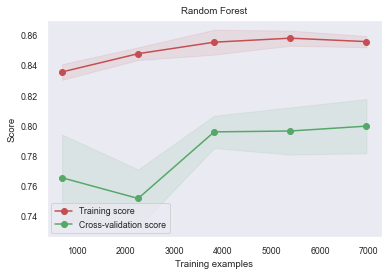

In [49]:
plot_learning_curve(RFC_best, 'Random Forest', X_train, Y_train)

In [50]:
# 3. extra trees tunning

ExtC = ExtraTreesClassifier(random_state=random_state)

ex_param_grid = {'max_depth':[18],
                'max_features':[0.5],
                'min_samples_split':[5],
                'min_samples_leaf':[15],
                'bootstrap':[False], # 당연히 extratrees는 bootstrap을 사용하지 않는다.
                'n_estimators':[550],
                'criterion':['gini'],}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=5, scoring='accuracy', verbose=1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

print('The Best model parameter is:')
print(ExtC_best)
print(f'With Cross validation score = {gsExtC.best_score_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
The Best model parameter is:
ExtraTreesClassifier(max_depth=18, max_features=0.5, min_samples_leaf=15,
                     min_samples_split=5, n_estimators=550, random_state=0)
With Cross validation score = 0.7967352902445819


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

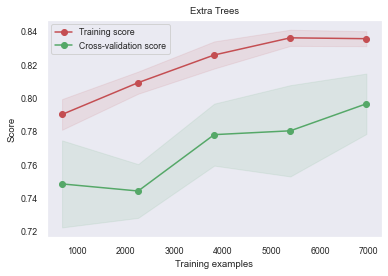

In [51]:
plot_learning_curve(ExtC_best, 'Extra Trees', X_train, Y_train)

In [52]:
# logistic regression tunning

LogReg = LogisticRegression(random_state=random_state)

log_reg_param_grid = {
    'C':[0.005],
    'max_iter' : [600]
}

gsLogReg = GridSearchCV(LogReg, param_grid = log_reg_param_grid, cv=5, scoring='accuracy', verbose=1)

gsLogReg.fit(X_train,Y_train)

LogReg_best = gsLogReg.best_estimator_

print('The best model parameter is: ')
print(LogReg_best)
print(f'With Cross validation score = {gsLogReg.best_score_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
The best model parameter is: 
LogisticRegression(C=0.005, max_iter=600, random_state=0)
With Cross validation score = 0.7889115935708987


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

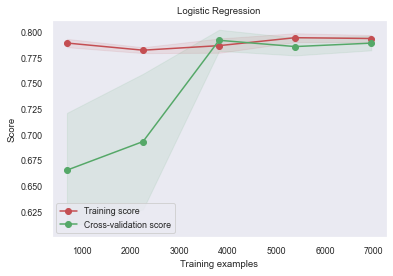

In [53]:
plot_learning_curve(LogReg_best, 'Logistic Regression', X_train, Y_train)